# cGAN

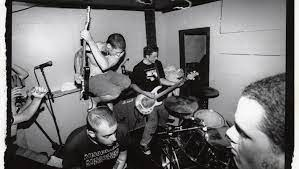

https://keras.io/examples/generative/conditional_gan/
https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
https://www.youtube.com/watch?v=DYGi18U4D4M

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [4]:
import sys
sys.path.append('..')
sys.path.append('/home/tnn1t1s/art/cpunks-10k')
import matplotlib.pyplot as plt
import cpunks.cpunks10k as cpunks10k
%matplotlib inline

In [5]:

# MNIST
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

# CPUNKS-10K
batch_size = 64
num_channels = 1
num_classes = 93
image_size = 24
latent_dim = 128


generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
(generator_in_channels, discriminator_in_channels)

(221, 94)

In [6]:
cp = cpunks10k.cpunks10k()
(X_train, Y_train), (X_test, Y_test), (labels) = cp.load_data()
df = cp.punks_df

### MNIST Load dataset

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset_mnist = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset_mnist = dataset_mnist.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")


Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


### CPUNKS-10k Load Dataset

In [9]:
cmap = plt.get_cmap('gray')
def rgb2gray(rgb):
    weights = [0.2989, 0.5870, 0.1140]
    return np.dot(rgb[...,:3], weights)

def drop_transparency(rgbt):
    return rgbt[...,:3]

X_train_g = np.array([rgb2gray(img) for img in X_train])
X_train_g = X_train_g.reshape(9000,24,24,1)
X_test_g = np.array([rgb2gray(img) for img in X_test])

X_train_rgb = np.array([drop_transparency(img) for img in X_train])
X_test_g = np.array([drop_transparency(img) for img in X_test])

dataset_cpunks = tf.data.Dataset.from_tensor_slices((X_train_rgb, Y_train))
dataset_cpunks = dataset_cpunks.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {X_train_rgb.shape}")
print(f"Shape of training labels: {Y_train.shape}")


Shape of training images: (9000, 24, 24, 3)
Shape of training labels: (9000, 93)


In [10]:
dataset=dataset_cpunks
print(dataset)

<BatchDataset shapes: ((None, 24, 24, 3), (None, 93)), types: (tf.float32, tf.int64)>


In [11]:

# define the standalone discriminator model
def define_discriminator(in_shape=(24, 24,3)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [13]:
define_discriminator().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       3584      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 128)         147584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6, 6, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_1 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [14]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 6 * 6
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((6, 6, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (6, 6), activation='tanh', padding='same'))
	return model

In [15]:
define_generator(100).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4608)              465408    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4608)              0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 24, 24, 128)      262272    
 ranspose)                                            

In [16]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [17]:

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [18]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [19]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [20]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

In [ ]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_train_rgb
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=60)

>1, 1/70, d1=0.695, d2=0.695 g=0.693
>1, 2/70, d1=0.651, d2=0.699 g=0.688
>1, 3/70, d1=0.614, d2=0.705 g=0.683
>1, 4/70, d1=0.587, d2=0.713 g=0.677
>1, 5/70, d1=0.552, d2=0.723 g=0.669
>1, 6/70, d1=0.533, d2=0.730 g=0.667
>1, 7/70, d1=0.488, d2=0.739 g=0.666
>1, 8/70, d1=0.462, d2=0.735 g=0.674
>1, 9/70, d1=0.446, d2=0.725 g=0.687
>1, 10/70, d1=0.418, d2=0.716 g=0.710
>1, 11/70, d1=0.411, d2=0.686 g=0.728
>1, 12/70, d1=0.393, d2=0.676 g=0.738
>1, 13/70, d1=0.365, d2=0.673 g=0.739
>1, 14/70, d1=0.350, d2=0.674 g=0.728
>1, 15/70, d1=0.348, d2=0.677 g=0.720
>1, 16/70, d1=0.307, d2=0.689 g=0.708
>1, 17/70, d1=0.256, d2=0.704 g=0.689
>1, 18/70, d1=0.255, d2=0.734 g=0.664
>1, 19/70, d1=0.226, d2=0.771 g=0.640
>1, 20/70, d1=0.200, d2=0.787 g=0.644
>1, 21/70, d1=0.223, d2=0.764 g=0.679
>1, 22/70, d1=0.172, d2=0.709 g=0.738
>1, 23/70, d1=0.181, d2=0.675 g=0.764
>1, 24/70, d1=0.195, d2=0.673 g=0.738
>1, 25/70, d1=0.199, d2=0.704 g=0.699
>1, 26/70, d1=0.171, d2=0.697 g=0.706
>1, 27/70, d1=0.148, 

>4, 8/70, d1=0.626, d2=0.562 g=0.923
>4, 9/70, d1=0.651, d2=0.588 g=0.903
>4, 10/70, d1=0.625, d2=0.560 g=0.897
>4, 11/70, d1=0.637, d2=0.587 g=0.882
>4, 12/70, d1=0.618, d2=0.583 g=0.884
>4, 13/70, d1=0.607, d2=0.582 g=0.884
>4, 14/70, d1=0.578, d2=0.608 g=0.873
>4, 15/70, d1=0.590, d2=0.598 g=0.871
>4, 16/70, d1=0.596, d2=0.569 g=0.869
>4, 17/70, d1=0.590, d2=0.606 g=0.883
>4, 18/70, d1=0.568, d2=0.596 g=0.868
>4, 19/70, d1=0.547, d2=0.595 g=0.877
>4, 20/70, d1=0.566, d2=0.591 g=0.872
>4, 21/70, d1=0.522, d2=0.601 g=0.865
>4, 22/70, d1=0.549, d2=0.613 g=0.864
>4, 23/70, d1=0.536, d2=0.592 g=0.856
>4, 24/70, d1=0.531, d2=0.629 g=0.838
>4, 25/70, d1=0.500, d2=0.636 g=0.835
>4, 26/70, d1=0.553, d2=0.623 g=0.820
>4, 27/70, d1=0.553, d2=0.641 g=0.847
>4, 28/70, d1=0.554, d2=0.637 g=0.850
>4, 29/70, d1=0.513, d2=0.621 g=0.846
>4, 30/70, d1=0.526, d2=0.621 g=0.852
>4, 31/70, d1=0.551, d2=0.610 g=0.857
>4, 32/70, d1=0.522, d2=0.595 g=0.858
>4, 33/70, d1=0.514, d2=0.575 g=0.891
>4, 34/70, d1=

>7, 15/70, d1=0.485, d2=0.544 g=0.993
>7, 16/70, d1=0.520, d2=0.555 g=1.001
>7, 17/70, d1=0.542, d2=0.555 g=0.978
>7, 18/70, d1=0.468, d2=0.521 g=1.036
>7, 19/70, d1=0.512, d2=0.522 g=1.030
>7, 20/70, d1=0.446, d2=0.496 g=1.074
>7, 21/70, d1=0.481, d2=0.528 g=1.016
>7, 22/70, d1=0.486, d2=0.512 g=1.027
>7, 23/70, d1=0.542, d2=0.529 g=1.046
>7, 24/70, d1=0.521, d2=0.501 g=1.057
>7, 25/70, d1=0.426, d2=0.496 g=1.101
>7, 26/70, d1=0.547, d2=0.455 g=1.182
>7, 27/70, d1=0.461, d2=0.501 g=1.072
>7, 28/70, d1=0.466, d2=0.402 g=1.227
>7, 29/70, d1=0.506, d2=0.445 g=1.145
>7, 30/70, d1=0.428, d2=0.460 g=1.154
>7, 31/70, d1=0.433, d2=0.501 g=1.085
>7, 32/70, d1=0.522, d2=0.472 g=1.171
>7, 33/70, d1=0.514, d2=0.481 g=1.179
>7, 34/70, d1=0.515, d2=0.436 g=1.195
>7, 35/70, d1=0.524, d2=0.467 g=1.239
>7, 36/70, d1=0.564, d2=0.513 g=1.228
>7, 37/70, d1=0.534, d2=0.476 g=1.286
>7, 38/70, d1=0.668, d2=0.449 g=1.238
>7, 39/70, d1=0.626, d2=0.451 g=1.311
>7, 40/70, d1=0.659, d2=0.434 g=1.371
>7, 41/70, d

>10, 21/70, d1=0.443, d2=0.545 g=1.061
>10, 22/70, d1=0.483, d2=0.527 g=1.086
>10, 23/70, d1=0.478, d2=0.472 g=1.120
>10, 24/70, d1=0.421, d2=0.553 g=1.042
>10, 25/70, d1=0.470, d2=0.530 g=1.082
>10, 26/70, d1=0.464, d2=0.473 g=1.086
>10, 27/70, d1=0.532, d2=0.544 g=1.031
>10, 28/70, d1=0.376, d2=0.504 g=1.059
>10, 29/70, d1=0.455, d2=0.537 g=1.025
>10, 30/70, d1=0.363, d2=0.495 g=1.075
>10, 31/70, d1=0.423, d2=0.530 g=1.033
>10, 32/70, d1=0.440, d2=0.521 g=1.074
>10, 33/70, d1=0.460, d2=0.498 g=1.077
>10, 34/70, d1=0.470, d2=0.459 g=1.099
>10, 35/70, d1=0.432, d2=0.514 g=1.038
>10, 36/70, d1=0.437, d2=0.478 g=1.079
>10, 37/70, d1=0.407, d2=0.523 g=1.067
>10, 38/70, d1=0.394, d2=0.507 g=1.045
>10, 39/70, d1=0.419, d2=0.469 g=1.109
>10, 40/70, d1=0.423, d2=0.473 g=1.125
>10, 41/70, d1=0.417, d2=0.547 g=1.027
>10, 42/70, d1=0.416, d2=0.509 g=1.074
>10, 43/70, d1=0.418, d2=0.500 g=1.077
>10, 44/70, d1=0.415, d2=0.526 g=1.109
>10, 45/70, d1=0.404, d2=0.432 g=1.167
>10, 46/70, d1=0.476, d2=

>13, 22/70, d1=0.450, d2=0.383 g=1.312
>13, 23/70, d1=0.418, d2=0.417 g=1.328
>13, 24/70, d1=0.489, d2=0.422 g=1.319
>13, 25/70, d1=0.380, d2=0.433 g=1.325
>13, 26/70, d1=0.504, d2=0.394 g=1.237
>13, 27/70, d1=0.452, d2=0.421 g=1.274
>13, 28/70, d1=0.463, d2=0.412 g=1.267
>13, 29/70, d1=0.448, d2=0.415 g=1.293
>13, 30/70, d1=0.443, d2=0.435 g=1.336
>13, 31/70, d1=0.510, d2=0.420 g=1.348
>13, 32/70, d1=0.471, d2=0.424 g=1.329
>13, 33/70, d1=0.448, d2=0.418 g=1.307
>13, 34/70, d1=0.487, d2=0.412 g=1.286
>13, 35/70, d1=0.449, d2=0.397 g=1.301
>13, 36/70, d1=0.439, d2=0.418 g=1.299
>13, 37/70, d1=0.436, d2=0.376 g=1.288
>13, 38/70, d1=0.560, d2=0.421 g=1.193
>13, 39/70, d1=0.437, d2=0.480 g=1.255
>13, 40/70, d1=0.477, d2=0.426 g=1.293
>13, 41/70, d1=0.519, d2=0.418 g=1.319
>13, 42/70, d1=0.457, d2=0.375 g=1.303
>13, 43/70, d1=0.458, d2=0.416 g=1.277
>13, 44/70, d1=0.470, d2=0.421 g=1.314
>13, 45/70, d1=0.435, d2=0.452 g=1.412
>13, 46/70, d1=0.378, d2=0.410 g=1.372
>13, 47/70, d1=0.411, d2=

>16, 23/70, d1=0.351, d2=0.326 g=1.591
>16, 24/70, d1=0.378, d2=0.310 g=1.551
>16, 25/70, d1=0.372, d2=0.358 g=1.548
>16, 26/70, d1=0.384, d2=0.352 g=1.467
>16, 27/70, d1=0.359, d2=0.341 g=1.548
>16, 28/70, d1=0.468, d2=0.382 g=1.434
>16, 29/70, d1=0.446, d2=0.383 g=1.365
>16, 30/70, d1=0.450, d2=0.419 g=1.333
>16, 31/70, d1=0.429, d2=0.464 g=1.385
>16, 32/70, d1=0.365, d2=0.350 g=1.535
>16, 33/70, d1=0.501, d2=0.409 g=1.333
>16, 34/70, d1=0.475, d2=0.401 g=1.356
>16, 35/70, d1=0.439, d2=0.395 g=1.459
>16, 36/70, d1=0.607, d2=0.412 g=1.337
>16, 37/70, d1=0.459, d2=0.462 g=1.390
>16, 38/70, d1=0.370, d2=0.391 g=1.475
>16, 39/70, d1=0.504, d2=0.426 g=1.290
>16, 40/70, d1=0.494, d2=0.390 g=1.371
>16, 41/70, d1=0.479, d2=0.406 g=1.338
>16, 42/70, d1=0.505, d2=0.509 g=1.360
>16, 43/70, d1=0.428, d2=0.372 g=1.449
>16, 44/70, d1=0.522, d2=0.467 g=1.284
>16, 45/70, d1=0.504, d2=0.516 g=1.240
>16, 46/70, d1=0.438, d2=0.488 g=1.367
>16, 47/70, d1=0.495, d2=0.422 g=1.352
>16, 48/70, d1=0.554, d2=

>19, 24/70, d1=0.359, d2=0.355 g=1.387
>19, 25/70, d1=0.400, d2=0.390 g=1.393
>19, 26/70, d1=0.367, d2=0.354 g=1.393
>19, 27/70, d1=0.329, d2=0.361 g=1.494
>19, 28/70, d1=0.460, d2=0.417 g=1.371
>19, 29/70, d1=0.351, d2=0.452 g=1.387
>19, 30/70, d1=0.422, d2=0.451 g=1.389
>19, 31/70, d1=0.393, d2=0.411 g=1.424
>19, 32/70, d1=0.460, d2=0.468 g=1.299
>19, 33/70, d1=0.441, d2=0.505 g=1.196
>19, 34/70, d1=0.517, d2=0.605 g=1.164
>19, 35/70, d1=0.623, d2=0.686 g=1.229
>19, 36/70, d1=0.497, d2=0.593 g=1.297
>19, 37/70, d1=0.601, d2=0.496 g=1.236
>19, 38/70, d1=0.541, d2=0.475 g=1.255
>19, 39/70, d1=0.537, d2=0.531 g=1.319
>19, 40/70, d1=0.621, d2=0.518 g=1.297
>19, 41/70, d1=0.641, d2=0.491 g=1.284
>19, 42/70, d1=0.577, d2=0.538 g=1.284
>19, 43/70, d1=0.605, d2=0.527 g=1.359
>19, 44/70, d1=0.590, d2=0.474 g=1.408
>19, 45/70, d1=0.623, d2=0.455 g=1.392
>19, 46/70, d1=0.560, d2=0.362 g=1.407
>19, 47/70, d1=0.579, d2=0.424 g=1.349
>19, 48/70, d1=0.528, d2=0.374 g=1.413
>19, 49/70, d1=0.430, d2=

>22, 25/70, d1=0.393, d2=0.397 g=1.361
>22, 26/70, d1=0.388, d2=0.391 g=1.419
>22, 27/70, d1=0.419, d2=0.380 g=1.429
>22, 28/70, d1=0.365, d2=0.437 g=1.473
>22, 29/70, d1=0.473, d2=0.371 g=1.515
>22, 30/70, d1=0.554, d2=0.358 g=1.385
>22, 31/70, d1=0.405, d2=0.354 g=1.419
>22, 32/70, d1=0.360, d2=0.351 g=1.608
>22, 33/70, d1=0.455, d2=0.417 g=1.468
>22, 34/70, d1=0.603, d2=0.332 g=1.521
>22, 35/70, d1=0.485, d2=0.317 g=1.427
>22, 36/70, d1=0.466, d2=0.432 g=1.328
>22, 37/70, d1=0.408, d2=0.338 g=1.500
>22, 38/70, d1=0.385, d2=0.351 g=1.451
>22, 39/70, d1=0.452, d2=0.444 g=1.366
>22, 40/70, d1=0.451, d2=0.449 g=1.434
>22, 41/70, d1=0.441, d2=0.345 g=1.489
>22, 42/70, d1=0.552, d2=0.417 g=1.304
>22, 43/70, d1=0.562, d2=0.387 g=1.297
>22, 44/70, d1=0.407, d2=0.451 g=1.384
>22, 45/70, d1=0.422, d2=0.432 g=1.454
>22, 46/70, d1=0.513, d2=0.423 g=1.475
>22, 47/70, d1=0.461, d2=0.383 g=1.458
>22, 48/70, d1=0.424, d2=0.377 g=1.549
>22, 49/70, d1=0.430, d2=0.366 g=1.513
>22, 50/70, d1=0.514, d2=

>25, 26/70, d1=0.511, d2=0.332 g=1.540
>25, 27/70, d1=0.377, d2=0.464 g=1.362
>25, 28/70, d1=0.499, d2=0.341 g=1.399
>25, 29/70, d1=0.371, d2=0.341 g=1.516
>25, 30/70, d1=0.374, d2=0.433 g=1.296
>25, 31/70, d1=0.330, d2=0.358 g=1.477
>25, 32/70, d1=0.450, d2=0.341 g=1.463
>25, 33/70, d1=0.366, d2=0.449 g=1.308
>25, 34/70, d1=0.367, d2=0.372 g=1.517
>25, 35/70, d1=0.447, d2=0.390 g=1.437
>25, 36/70, d1=0.315, d2=0.423 g=1.418
>25, 37/70, d1=0.399, d2=0.321 g=1.536
>25, 38/70, d1=0.492, d2=0.376 g=1.470
>25, 39/70, d1=0.344, d2=0.451 g=1.330
>25, 40/70, d1=0.469, d2=0.383 g=1.420
>25, 41/70, d1=0.392, d2=0.309 g=1.545
>25, 42/70, d1=0.416, d2=0.414 g=1.354
>25, 43/70, d1=0.415, d2=0.328 g=1.456
>25, 44/70, d1=0.418, d2=0.333 g=1.485
>25, 45/70, d1=0.437, d2=0.422 g=1.322
>25, 46/70, d1=0.383, d2=0.413 g=1.415
>25, 47/70, d1=0.420, d2=0.334 g=1.474
>25, 48/70, d1=0.414, d2=0.447 g=1.361
>25, 49/70, d1=0.429, d2=0.367 g=1.466
>25, 50/70, d1=0.365, d2=0.366 g=1.467
>25, 51/70, d1=0.319, d2=

>28, 27/70, d1=0.605, d2=0.414 g=1.476
>28, 28/70, d1=0.434, d2=0.451 g=1.418
>28, 29/70, d1=0.502, d2=0.455 g=1.469
>28, 30/70, d1=0.575, d2=0.424 g=1.503
>28, 31/70, d1=0.489, d2=0.438 g=1.399
>28, 32/70, d1=0.491, d2=0.437 g=1.352
>28, 33/70, d1=0.469, d2=0.452 g=1.442
>28, 34/70, d1=0.589, d2=0.487 g=1.353
>28, 35/70, d1=0.583, d2=0.493 g=1.308
>28, 36/70, d1=0.433, d2=0.403 g=1.372
>28, 37/70, d1=0.470, d2=0.466 g=1.380
>28, 38/70, d1=0.402, d2=0.404 g=1.444
>28, 39/70, d1=0.568, d2=0.408 g=1.446
>28, 40/70, d1=0.418, d2=0.435 g=1.359
>28, 41/70, d1=0.490, d2=0.393 g=1.430
>28, 42/70, d1=0.552, d2=0.463 g=1.332
>28, 43/70, d1=0.460, d2=0.370 g=1.450
>28, 44/70, d1=0.437, d2=0.341 g=1.486
>28, 45/70, d1=0.452, d2=0.450 g=1.311
>28, 46/70, d1=0.412, d2=0.353 g=1.522
>28, 47/70, d1=0.465, d2=0.331 g=1.500
>28, 48/70, d1=0.426, d2=0.409 g=1.315
>28, 49/70, d1=0.380, d2=0.369 g=1.648
>28, 50/70, d1=0.478, d2=0.344 g=1.428
>28, 51/70, d1=0.464, d2=0.485 g=1.340
>28, 52/70, d1=0.454, d2=

>31, 28/70, d1=0.467, d2=0.367 g=1.403
>31, 29/70, d1=0.417, d2=0.352 g=1.466
>31, 30/70, d1=0.423, d2=0.400 g=1.409
>31, 31/70, d1=0.411, d2=0.451 g=1.466
>31, 32/70, d1=0.395, d2=0.351 g=1.432
>31, 33/70, d1=0.439, d2=0.361 g=1.408
>31, 34/70, d1=0.482, d2=0.452 g=1.402
>31, 35/70, d1=0.412, d2=0.356 g=1.453
>31, 36/70, d1=0.399, d2=0.394 g=1.523
>31, 37/70, d1=0.599, d2=0.331 g=1.371
>31, 38/70, d1=0.390, d2=0.439 g=1.367
>31, 39/70, d1=0.362, d2=0.390 g=1.422
>31, 40/70, d1=0.442, d2=0.400 g=1.387
>31, 41/70, d1=0.494, d2=0.396 g=1.388
>31, 42/70, d1=0.508, d2=0.410 g=1.368
>31, 43/70, d1=0.344, d2=0.350 g=1.413
>31, 44/70, d1=0.444, d2=0.451 g=1.494
>31, 45/70, d1=0.368, d2=0.332 g=1.488
>31, 46/70, d1=0.517, d2=0.283 g=1.503
>31, 47/70, d1=0.354, d2=0.461 g=1.306
>31, 48/70, d1=0.526, d2=0.384 g=1.375
>31, 49/70, d1=0.418, d2=0.330 g=1.509
>31, 50/70, d1=0.449, d2=0.418 g=1.337
>31, 51/70, d1=0.434, d2=0.325 g=1.430
>31, 52/70, d1=0.450, d2=0.318 g=1.475
>31, 53/70, d1=0.482, d2=

>34, 29/70, d1=0.357, d2=0.393 g=1.506
>34, 30/70, d1=0.511, d2=0.384 g=1.329
>34, 31/70, d1=0.479, d2=0.422 g=1.411
>34, 32/70, d1=0.423, d2=0.339 g=1.417
>34, 33/70, d1=0.313, d2=0.431 g=1.320
>34, 34/70, d1=0.412, d2=0.361 g=1.416
>34, 35/70, d1=0.448, d2=0.352 g=1.487
>34, 36/70, d1=0.428, d2=0.409 g=1.390
>34, 37/70, d1=0.428, d2=0.355 g=1.533
>34, 38/70, d1=0.428, d2=0.361 g=1.469
>34, 39/70, d1=0.433, d2=0.393 g=1.297
>34, 40/70, d1=0.460, d2=0.371 g=1.492
>34, 41/70, d1=0.374, d2=0.376 g=1.425
>34, 42/70, d1=0.393, d2=0.447 g=1.332
>34, 43/70, d1=0.462, d2=0.398 g=1.436
>34, 44/70, d1=0.418, d2=0.345 g=1.386
>34, 45/70, d1=0.474, d2=0.471 g=1.366
>34, 46/70, d1=0.425, d2=0.343 g=1.597
>34, 47/70, d1=0.418, d2=0.365 g=1.480
>34, 48/70, d1=0.402, d2=0.396 g=1.392
>34, 49/70, d1=0.418, d2=0.397 g=1.474
>34, 50/70, d1=0.448, d2=0.342 g=1.436
>34, 51/70, d1=0.370, d2=0.453 g=1.315
>34, 52/70, d1=0.433, d2=0.349 g=1.474
>34, 53/70, d1=0.478, d2=0.355 g=1.444
>34, 54/70, d1=0.350, d2=

>37, 30/70, d1=0.463, d2=0.437 g=1.397
>37, 31/70, d1=0.401, d2=0.362 g=1.469
>37, 32/70, d1=0.452, d2=0.345 g=1.357
>37, 33/70, d1=0.452, d2=0.400 g=1.242
>37, 34/70, d1=0.299, d2=0.367 g=1.432
>37, 35/70, d1=0.340, d2=0.405 g=1.418
>37, 36/70, d1=0.467, d2=0.356 g=1.516
>37, 37/70, d1=0.404, d2=0.320 g=1.555
>37, 38/70, d1=0.400, d2=0.424 g=1.545
>37, 39/70, d1=0.379, d2=0.346 g=1.480
>37, 40/70, d1=0.470, d2=0.351 g=1.366
>37, 41/70, d1=0.374, d2=0.469 g=1.294
>37, 42/70, d1=0.435, d2=0.352 g=1.517
>37, 43/70, d1=0.453, d2=0.345 g=1.527
>37, 44/70, d1=0.425, d2=0.385 g=1.306
>37, 45/70, d1=0.406, d2=0.386 g=1.473
>37, 46/70, d1=0.367, d2=0.391 g=1.476
>37, 47/70, d1=0.426, d2=0.448 g=1.428
>37, 48/70, d1=0.474, d2=0.425 g=1.483
>37, 49/70, d1=0.407, d2=0.313 g=1.548
>37, 50/70, d1=0.387, d2=0.385 g=1.489
>37, 51/70, d1=0.340, d2=0.274 g=1.669
>37, 52/70, d1=0.414, d2=0.308 g=1.490
>37, 53/70, d1=0.366, d2=0.449 g=1.468
>37, 54/70, d1=0.484, d2=0.317 g=1.544
>37, 55/70, d1=0.452, d2=

>40, 31/70, d1=0.506, d2=0.444 g=1.495
>40, 32/70, d1=0.473, d2=0.396 g=1.707
>40, 33/70, d1=0.514, d2=0.405 g=1.629
>40, 34/70, d1=0.459, d2=0.386 g=1.661
>40, 35/70, d1=0.446, d2=0.387 g=1.520
>40, 36/70, d1=0.406, d2=0.402 g=1.582
>40, 37/70, d1=0.440, d2=0.393 g=1.598
>40, 38/70, d1=0.341, d2=0.422 g=1.654
>40, 39/70, d1=0.406, d2=0.350 g=1.649
>40, 40/70, d1=0.517, d2=0.398 g=1.723
>40, 41/70, d1=0.497, d2=0.365 g=1.721
>40, 42/70, d1=0.457, d2=0.430 g=1.580
>40, 43/70, d1=0.371, d2=0.376 g=1.527
>40, 44/70, d1=0.479, d2=0.396 g=1.565
>40, 45/70, d1=0.415, d2=0.425 g=1.460
>40, 46/70, d1=0.382, d2=0.426 g=1.565
>40, 47/70, d1=0.467, d2=0.341 g=1.514
>40, 48/70, d1=0.445, d2=0.405 g=1.378
>40, 49/70, d1=0.493, d2=0.448 g=1.580
>40, 50/70, d1=0.372, d2=0.339 g=1.474
>40, 51/70, d1=0.419, d2=0.380 g=1.525
>40, 52/70, d1=0.486, d2=0.457 g=1.348
>40, 53/70, d1=0.392, d2=0.412 g=1.570
>40, 54/70, d1=0.475, d2=0.433 g=1.625
>40, 55/70, d1=0.434, d2=0.326 g=1.634
>40, 56/70, d1=0.427, d2=

In [32]:

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)


In [34]:
X[0]

array([[[ 0.06071326, -0.00823038,  0.02585868],
        [ 0.05762538,  0.0120746 ,  0.00795003],
        [ 0.07200203,  0.07176816,  0.03886728],
        ...,
        [ 0.02610362,  0.03015628,  0.02631207],
        [-0.00533437,  0.02175211,  0.02570006],
        [-0.00538795,  0.00476934, -0.0007807 ]],

       [[ 0.03174607,  0.01436934,  0.02104966],
        [ 0.05749048,  0.01298515,  0.04161718],
        [ 0.04789097,  0.04264637,  0.01624763],
        ...,
        [ 0.00195988,  0.01349509,  0.0362917 ],
        [-0.01508091,  0.02047714, -0.00038947],
        [-0.0009584 ,  0.0090647 ,  0.00425506]],

       [[ 0.05144014,  0.00078538,  0.06315093],
        [ 0.10916486,  0.07456587,  0.04040373],
        [ 0.09668656,  0.05039641,  0.05023102],
        ...,
        [ 0.00565919,  0.03174765, -0.02017404],
        [ 0.02223497,  0.02422718,  0.01761548],
        [-0.00133866,  0.03037156,  0.00491991]],

       ...,

       [[-0.04135573, -0.05599646, -0.05076549],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


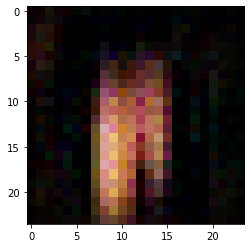

In [38]:
plt.imshow(X[15])